In [1]:
from pathlib import Path

import torch
import numpy as np
import random
import pickle
from absl import logging
from absl.flags import FLAGS
from cellot import losses
from cellot.utils.loaders import load
from cellot.models.cellot import compute_loss_f, compute_loss_g, compute_w2_distance
from cellot.train.summary import Logger
from cellot.data.utils import cast_loader_to_iterator
from cellot.models.ae import compute_scgen_shift
from tqdm import trange
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
TARGET = 'all' # 'all' denotes all drugs

In [3]:
import omegaconf

yaml_str = f"""
model:
   name: scgen
   beta: 0.0
   dropout: 0.0
   hidden_units: [512, 512]
   latent_dim: 50

optim:
   lr: 0.001
   optimizer: Adam
   weight_decay: 1.0e-05

scheduler:
   gamma: 0.5
   step_size: 100000

training:
  cache_freq: 10000
  eval_freq: 2500
  logs_freq: 250
  n_iters: 250000

data:
  type: cell
  source: control
  condition: drug
  path: /Mounts/rbg-storage1/users/johnyang/cellot/datasets/scrna-sciplex3/hvg.h5ad
  target: {TARGET}

datasplit:
    groupby: drug   
    name: train_test
    test_size: 0.2
    random_state: 0

dataloader:
    batch_size: 256
    shuffle: true
"""

config = omegaconf.OmegaConf.create(yaml_str)

### Utils

In [4]:
def load_lr_scheduler(optim, config):
    if "scheduler" not in config:
        return None

    return torch.optim.lr_scheduler.StepLR(optim, **config.scheduler)

def check_loss(*args):
    for arg in args:
        if torch.isnan(arg):
            raise ValueError


def load_item_from_save(path, key, default):
    path = Path(path)
    if not path.exists():
        return default

    ckpt = torch.load(path)
    if key not in ckpt:
        logging.warn(f"'{key}' not found in ckpt: {str(path)}")
        return default

    return ckpt[key]

In [5]:
import cellot.models
from cellot.data.cell import load_cell_data


def load_data(config, **kwargs):
    data_type = config.get("data.type", "cell")
    if data_type in ["cell", "cell-merged", "tupro-cohort"]:
        loadfxn = load_cell_data

    elif data_type == "toy":
        loadfxn = load_toy_data

    else:
        raise ValueError

    return loadfxn(config, **kwargs)


def load_model(config, restore=None, **kwargs):
    name = config.model.name
    if name == "cellot":
        loadfxn = cellot.models.load_cellot_model

    elif name == "scgen":
        loadfxn = cellot.models.load_autoencoder_model

    elif name == "cae":
        loadfxn = cellot.models.load_autoencoder_model

    elif name == "popalign":
        loadfxn = cellot.models.load_popalign_model

    else:
        raise ValueError

    return loadfxn(config, restore=restore, **kwargs)


def load(config, restore=None, include_model_kwargs=False, **kwargs):

    loader, model_kwargs = load_data(config, include_model_kwargs=True, **kwargs)

    model, opt = load_model(config, restore=restore, **model_kwargs)

    if include_model_kwargs:
        return model, opt, loader, model_kwargs

    return model, opt, loader

### Outdir

In [6]:
import torch
import GPUtil
import os

def get_free_gpu():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(device)
    # Set environment variables for which GPUs to use.
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    chosen_gpu = ''.join(
        [str(x) for x in GPUtil.getAvailable(order='memory')])
    os.environ["CUDA_VISIBLE_DEVICES"] = chosen_gpu
    print(f"Using GPUs: {chosen_gpu}")
    return chosen_gpu

In [7]:
device = f'cuda:{get_free_gpu()}'

cuda
Using GPUs: 6


In [26]:
from pathlib import Path
outdir_path = '/Mounts/rbg-storage1/users/johnyang/cellot/saved_weights/ae'
outdir = Path(outdir_path)

In [27]:
def evaluate(vinputs, tmodel):
    with torch.no_grad():
        loss, comps, outs = tmodel(vinputs)
        loss = loss.mean()
        comps = {k: v.mean().item() for k, v in comps._asdict().items()}
        check_loss(loss)
        logger.log("eval", loss=loss.item(), step=step, **comps)
    return loss, outs

logger = Logger(outdir / "cache/scalars")
cachedir = outdir / "cache"
model, optim, loader = load(config, restore=outdir / "ae.pt")

scheduler = load_lr_scheduler(optim, config)

n_iters = config.training.n_iters
step = load_item_from_save(cachedir / "last.pt", "step", 0)
if scheduler is not None and step > 0:
    scheduler.last_epoch = step

best_eval_loss = load_item_from_save(
    cachedir / "model.pt", "best_eval_loss", np.inf
)

eval_loss = best_eval_loss

eval_losses = []

trues = []
preds = []

for batch in tqdm(loader.test):
    model.eval()
    eval_loss, outs = evaluate(batch, model)
    eval_losses.append(eval_loss)
    trues.append(batch)
    preds.append(outs)
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
    

2023-07-12 14:18:12,749 Loaded cell data with TARGET all and OBS SHAPE (762039, 16)
100%|██████████| 595/595 [00:06<00:00, 92.61it/s]


In [28]:
sum(eval_losses) / len(eval_losses)

tensor(0.0811)

In [29]:
import anndata
path = '/Mounts/rbg-storage1/users/johnyang/cellot/datasets/scrna-sciplex3/hvg.h5ad'
adata = anndata.read(path)

In [30]:
from scipy.stats import spearmanr


In [31]:
def get_true_and_pred_cells(trues, preds, batch_size=256):
    true_scs = [x[i] for i in range(batch_size) for x in trues]
    pred_scs = [x.recon[i] for i in range(batch_size) for x in preds]
    assert len(true_scs) == len(pred_scs), 'amt of true cells neq pred cells'

    return torch.stack(true_scs, dim=0), torch.stack(pred_scs, dim=0)

In [32]:
true_scs, pred_scs = get_true_and_pred_cells(trues, preds)

In [33]:
true_scs.shape

torch.Size([152320, 1000])

In [34]:
pred_scs.shape

torch.Size([152320, 1000])

In [35]:
true_values_np = true_scs.cpu().numpy()
reconstructed_values_np = pred_scs.cpu().numpy()

correlations = []

# Loop through each gene (assuming genes are the columns)
for i in range(true_values_np.shape[1]):
    correlation, _ = spearmanr(true_values_np[:, i], reconstructed_values_np[:, i])
    correlations.append(correlation)

# Convert list of correlations to a tensor
correlations_tensor = torch.tensor(correlations)

In [36]:
correlations_tensor.shape

torch.Size([1000])

In [37]:
var_df = adata.var
var_df.head()

,gene_short_name,n_cells,highly_variable,means,dispersions,dispersions_norm
id,,,,,,
ENSG00000243620.1,AC092957.1,17880,True,0.364202,4.172572,12.212371
ENSG00000271503.5,CCL5,860,True,0.014860,4.311270,11.307179
ENSG00000259124.1,AC008050.1,12455,True,0.305440,4.294063,11.216585
ENSG00000121101.15,TEX14,74984,True,0.672128,4.004683,11.155469
ENSG00000160963.13,COL26A1,29574,True,0.748154,4.410117,10.970569


In [38]:
var_df['spearmanr_recon'] = correlations

In [39]:
var_df

,gene_short_name,n_cells,highly_variable,means,dispersions,dispersions_norm,spearmanr_recon
id,,,,,,,
ENSG00000243620.1,AC092957.1,17880,True,0.364202,4.172572,12.212371,0.175826
ENSG00000271503.5,CCL5,860,True,0.014860,4.311270,11.307179,-0.001919
ENSG00000259124.1,AC008050.1,12455,True,0.305440,4.294063,11.216585,0.148780
ENSG00000121101.15,TEX14,74984,True,0.672128,4.004683,11.155469,0.492539
ENSG00000160963.13,COL26A1,29574,True,0.748154,4.410117,10.970569,0.235145
...,...,...,...,...,...,...,...
ENSG00000227124.8,ZNF717,11416,True,0.103680,2.456312,1.540970,0.078726
ENSG00000280081.3,LINC01667,3381,True,0.033455,2.456225,1.540514,0.076620
ENSG00000270019.1,AC110769.2,2885,True,0.020736,2.456221,1.540488,0.021434


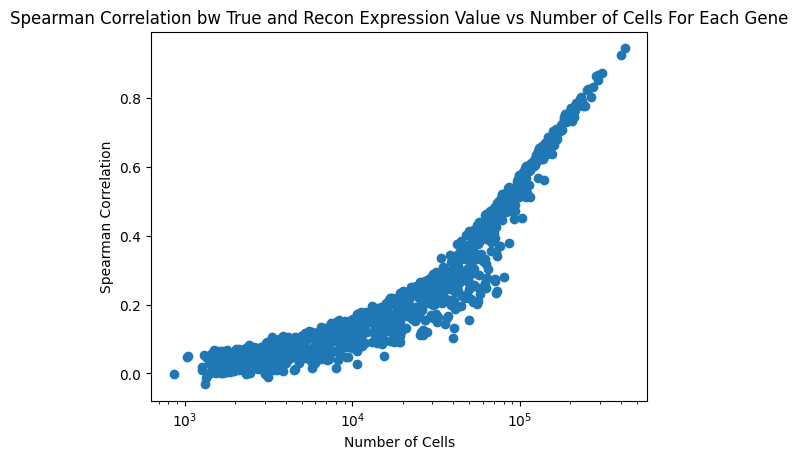

In [40]:
import matplotlib.pyplot as plt

plt.scatter(var_df['n_cells'], var_df['spearmanr_recon'])
plt.xscale('log')  # sets the x-axis to a logarithmic scale
plt.xlabel('Number of Cells')
plt.ylabel('Spearman Correlation')
plt.title('Spearman Correlation bw True and Recon Expression Value vs Number of Cells For Each Gene')
plt.show()


In [41]:
sorted_spearman = var_df.sort_values(by='spearmanr_recon', ascending=False)

In [46]:
sorted_spearman.head()

,gene_short_name,n_cells,highly_variable,means,dispersions,dispersions_norm,spearmanr_recon
id,,,,,,,
ENSG00000170921.15,TANC2,422727,True,2.582102,3.243572,1.904368,0.944853
ENSG00000185305.10,ARL15,403964,True,2.118916,3.087871,1.566747,0.925634
ENSG00000074410.13,CA12,311128,True,1.950621,3.101116,1.607566,0.874188
ENSG00000149485.18,FADS1,292092,True,1.679964,3.006801,1.939378,0.866289
ENSG00000251574.6,AC099520.1,286116,True,1.967979,3.457096,2.704655,0.863859


In [45]:
sorted_spearman.index

Index(['ENSG00000170921.15', 'ENSG00000185305.10', 'ENSG00000074410.13',
       'ENSG00000149485.18', 'ENSG00000251574.6', 'ENSG00000113448.18',
       'ENSG00000160182.2', 'ENSG00000108846.15', 'ENSG00000159023.19',
       'ENSG00000184226.14',
       ...
       'ENSG00000269926.1', 'ENSG00000185988.12', 'ENSG00000245164.6',
       'ENSG00000167984.17', 'ENSG00000232072.1', 'ENSG00000251557.2',
       'ENSG00000271503.5', 'ENSG00000253363.5', 'ENSG00000110852.4',
       'ENSG00000175538.10'],
      dtype='object', name='id', length=1000)

In [47]:
sorted_spearman.to_csv('sorted_spearman.csv')

In [54]:
adata.obs['drug'].value_counts()[:50]

control                   17565
ellagic_acid               6255
divalproex_sodium          6198
ruxolitinib                6139
mc1568                     6120
unc1999                    6085
tazemetostat               6032
fasudil_hcl                6000
pfi_1                      5945
resveratrol                5941
srt2104                    5934
bms_911543                 5922
iniparib                   5918
selisistat                 5918
roxadustat                 5894
g007_lk                    5882
eed226                     5849
srt3025_hcl                5821
flll32                     5734
_jq1                       5727
tmp195                     5699
ofloxacin                  5651
azacitidine                5614
aurora_a_inhibitor_i       5515
itsa_1                     5481
decitabine                 5316
rucaparib_phosphate        5291
pci_34051                  5169
tucidinostat               5022
2_methoxyestradiol         5005
jnj_7706621                4881
belinost

In [51]:
adata.obs.target

A01_E09_RT_BC_100_Lig_BC_147           Aurora Kinase
A01_E09_RT_BC_100_Lig_BC_186                    EGFR
A01_E09_RT_BC_100_Lig_BC_196                    HDAC
A01_E09_RT_BC_100_Lig_BC_213           Aurora Kinase
A01_E09_RT_BC_100_Lig_BC_220           DNA alkylator
                                        ...         
H12_F10_RT_BC_9_Lig_BC_23                        MEK
H12_F10_RT_BC_9_Lig_BC_237      Src,Sirtuin,PKC,PI3K
H12_F10_RT_BC_9_Lig_BC_274         Androgen Receptor
H12_F10_RT_BC_9_Lig_BC_291                      PARP
H12_F10_RT_BC_9_Lig_BC_298                       PKC
Name: target, Length: 762039, dtype: category
Categories (87, object): ['ALK,c-Met', 'AMPK', 'Androgen Receptor', 'Aromatase', ..., 'c-Met,Tie-2,VEGFR', 'c-RET,FLT3,JAK', 'c-RET,VEGFR', 'mTOR']

In [128]:
correlation, pvalue = spearmanr(true_scs, pred_scs)

print(f"Spearman's correlation: {correlation}")

Spearman's correlation: [[ 1.         -0.00112067  0.23067381 ...  0.00781666  0.07506989
   0.06175844]
 [-0.00112067  1.         -0.0011048  ...  0.00758568  0.00378346
   0.00637583]
 [ 0.23067381 -0.0011048   1.         ... -0.02626221  0.05145964
  -0.02354935]
 ...
 [ 0.00781666  0.00758568 -0.02626221 ...  1.          0.05086441
   0.01965921]
 [ 0.07506989  0.00378346  0.05145964 ...  0.05086441  1.
   0.08916642]
 [ 0.06175844  0.00637583 -0.02354935 ...  0.01965921  0.08916642
   1.        ]]


In [130]:
correlation.shape

(2000, 2000)

In [55]:
train_trues = []
pred_trues = []
for batch in tqdm(loader.train):
    model.eval()
    eval_loss, outs = evaluate(batch, model)
    eval_losses.append(eval_loss)
    train_trues.append(batch)
    pred_trues.append(outs)


  0%|          | 0/2381 [00:00<?, ?it/s]

100%|██████████| 2381/2381 [00:26<00:00, 89.94it/s]


In [55]:
compare_true_and_pred_hist(train_trues, pred_trues, 632)

NameError: name 'train_trues' is not defined

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

2023-06-23 14:49:23,730 Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-06-23 14:49:23,732 Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-06-23 14:49:23,733 NumExpr defaulting to 8 threads.


In [51]:
adata.var

,gene_short_name,n_cells,highly_variable,means,dispersions,dispersions_norm
id,,,,,,
ENSG00000243620.1,AC092957.1,17880,True,0.364202,4.172572,12.212371
ENSG00000271503.5,CCL5,860,True,0.014860,4.311270,11.307179
ENSG00000259124.1,AC008050.1,12455,True,0.305440,4.294063,11.216585
ENSG00000121101.15,TEX14,74984,True,0.672128,4.004683,11.155469
ENSG00000160963.13,COL26A1,29574,True,0.748154,4.410117,10.970569
...,...,...,...,...,...,...
ENSG00000227124.8,ZNF717,11416,True,0.103680,2.456312,1.540970
ENSG00000280081.3,LINC01667,3381,True,0.033455,2.456225,1.540514
ENSG00000270019.1,AC110769.2,2885,True,0.020736,2.456221,1.540488


In [53]:
adata.var['original_index'] = range(len(adata.var))
adata.var

,gene_short_name,n_cells,highly_variable,means,dispersions,dispersions_norm,original_index
id,,,,,,,
ENSG00000243620.1,AC092957.1,17880,True,0.364202,4.172572,12.212371,0
ENSG00000271503.5,CCL5,860,True,0.014860,4.311270,11.307179,1
ENSG00000259124.1,AC008050.1,12455,True,0.305440,4.294063,11.216585,2
ENSG00000121101.15,TEX14,74984,True,0.672128,4.004683,11.155469,3
ENSG00000160963.13,COL26A1,29574,True,0.748154,4.410117,10.970569,4
...,...,...,...,...,...,...,...
ENSG00000227124.8,ZNF717,11416,True,0.103680,2.456312,1.540970,995
ENSG00000280081.3,LINC01667,3381,True,0.033455,2.456225,1.540514,996
ENSG00000270019.1,AC110769.2,2885,True,0.020736,2.456221,1.540488,997


In [82]:
adata.var.sort_values('n_cells', ignore_index=False)

,gene_short_name,n_cells,highly_variable,means,dispersions,dispersions_norm,original_index
id,,,,,,,
ENSG00000271503.5,CCL5,860,True,0.014860,4.311270,11.307179,1
ENSG00000185862.6,EVI2B,1034,True,0.013799,2.688338,2.762566,238
ENSG00000244682.7,FCGR2C,1042,True,0.013169,2.597733,2.285542,399
ENSG00000130176.7,CNN1,1271,True,0.012791,2.457834,1.548983,979
ENSG00000226317.2,LINC00351,1277,True,0.012877,2.800029,3.350612,151
...,...,...,...,...,...,...,...
ENSG00000113448.18,PDE4D,291980,True,2.875985,3.917803,1.984414,565
ENSG00000149485.18,FADS1,292092,True,1.679964,3.006801,1.939378,599
ENSG00000074410.13,CA12,311128,True,1.950621,3.101116,1.607566,917


In [67]:
adata.var.sort_values('n_cells', ignore_index=False).iloc[500]

gene_short_name        PLIN2
n_cells                18972
highly_variable         True
means               0.154229
dispersions         2.479784
dispersions_norm    1.664546
original_index           845
Name: ENSG00000147872.9, dtype: object

In [80]:
adata.var.sort_values('n_cells', ignore_index=False).iloc[700]

gene_short_name      ZNF804B
n_cells                44170
highly_variable         True
means                 0.3644
dispersions         2.847575
dispersions_norm    3.871206
original_index           107
Name: ENSG00000182348.6, dtype: object